# Purchase Journey Analysis

This notebook focuses on users who eventually make a purchase, analyzing all their sessions leading up to that purchase event using previously defined categories.

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

# Load the same dataset as in sessions_deepdive.ipynb
df = pd.read_csv('analytics.csv')

# Set the same colors as in the original notebook for consistency
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
facecolor = '#F5F5F5'

In [37]:
def domainToName(str):
    name = str.split('.')[0]
    if name == "hm": return "H&M"
    return name.capitalize()


## Individual User Purchase Journey Visualization

To better understand the specific path users take before making a purchase, let's visualize individual user journeys. This will show us the sequence of session types that lead to a purchase event.

In [38]:
# Select a few interesting users with multiple sessions before purchase for case studies
# We'll look for users with different patterns to show variety in purchase journeys

df = pd.read_csv('analytics.csv')
df['timestamp'] = pd.to_datetime(df['created_at'], format='ISO8601')
only_show_events = ['place-order', 'enforce_wait_modal_shown', 'active', 'add-to-cart', 'uninstall', 'checkout', 'page-view']
interesting_df = df[df['type'].isin(only_show_events)]
# Find users with multiple pre-purchase sessions (3+) for more interesting journeys
# Group data by user_id and analyze their journey
buying_session_ids = df[df['type'].isin(['enforce_wait_modal_shown', 'place-order'])]['session_id'].unique()

# Filter out sessions that are not in the buying session IDs
sessions_df = interesting_df[interesting_df['session_id'].isin(buying_session_ids)]


print(len(buying_session_ids))


16


In [39]:
# ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']  [s, D, o, X]
# Determine session type color and marker
# Create a lookup dictionary for event styling
event_styles = {
    'enforce_wait_modal_shown': {'color': 'salmon', 'marker': 's', 'size': 150, 'zorder': 5},
    'place-order': {'color': '#000', 'marker': '|', 'size': 300, 'zorder': 20},
    'add-to-cart': {'color': '#106ED3', 'marker': 'x', 'size': 100, 'zorder': 25},
    'checkout': {'color': '#73FABD', 'marker': 'D', 'size': 100, 'zorder': 10},
    'page-view': {'color': '#6ED1F8', 'marker': '.', 'size': 80, 'zorder': 20},
    'workaround': {'color': '#000', 'marker': '|', 'size': 300, 'zorder': 20}
}

session_timelines = []
for buying_session in buying_session_ids:
    # Prepare data for visualization
    timeline_data = []
    session_df = df[df['session_id'] == buying_session].copy()
    for _, session in session_df.iterrows():
        time_from_first = (session['timestamp'] - session_df['timestamp'].min()).total_seconds()

        workaround = None

        # differentiate between active and deactivate by assessing payload == 'true'
        if session['type'] == 'uninstall':
            workaround = 'Uninstall'
        elif session['type'] == 'active':
            if session['payload'] == 'true':
                workaround = 'Activate'
            else:
                workaround = 'Deactivate'

        # Apply the styling based on session type
        if session['type'] in event_styles:
            style = event_styles[session['type']]
            color, marker, size, zorder = style['color'], style['marker'], style['size'], style['zorder']
        elif workaround:
            style = event_styles['workaround']
            color, marker, size, zorder = style['color'], style['marker'], style['size'], style['zorder']
        else:  continue

        timeline_data.append({
            'session_id': session['session_id'],
            'user_id': session['user_id'],
            'type': session['type'],
            'timestamp': session['timestamp'],
            'time': time_from_first,
            'domain': session['domain'],
            'workaround': workaround,
            'color': color,
            'marker': marker,
            'size': size,
            'zorder': zorder
        })

    # Adjust x-coordinates for better spacing when events are too close
    # Sort by time
    timeline_data.sort(key=lambda x: x['time'])
    session_timelines.append(timeline_data)
    """
    # Adjust positions
    # Create the timeline visualization
    plt.figure(figsize=(14, 4), facecolor=facecolor)
    
    # Plot each session as a point
    for event in timeline_data:
        plt.scatter(
            event['time'], 
            0.5,  # Fixed y-position for timeline
            color=event['color'],
            s=event['size'],
            marker=event['marker'],
            zorder=event['zorder'],
            edgecolors='black',
            linewidth=1
        )

        if event['workaround']:
            # Add flow category label above point with more vertical space
            # Do this for all sessions, including purchase sessions
            plt.text(
                event['time'],
                0.65,  # Increased vertical position
                event['workaround'],
                ha='center',
                va='bottom',
                fontsize=12,  # Slightly larger font
                color='black',
            )
    
    domain = session_df['domain'].iloc[0]
    # Set up the plot with improved aesthetics
    plt.title(f'User Journey to Purchase {domain}', fontsize=16)
    plt.xlabel('Days from First Session (adjusted for visibility)', fontsize=12)
    plt.yticks([])
    plt.grid(True, axis='x', alpha=0.2)

    
    # Add padding to x-axis for better appearance
    plt.xlim(left=timeline_data[0]['time'] - 50, right=timeline_data[-1]['time'] + 50)
    plt.ylim(0, 1)
    
    # Add a legend with improved positioning
    legend_elements = [
        plt.Line2D([0], [0], marker='.', color='w', markerfacecolor=colors[0], markersize=10, label='Page View'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=10, label='Checkout'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#6ED1F8', markersize=10, label='Add to Cart'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=10, label='Enforce Wait Modal'),
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add note about adjusted timeline
    plt.text(0.98, 0.02, "Note: Timeline spacing adjusted for readability", 
                transform=plt.gca().transAxes,
                va='bottom', ha='right', fontsize=8, fontstyle='italic', color='gray')
    
    plt.tight_layout()
    plt.show()"""

In [40]:
for i, timelines in enumerate(session_timelines):

    # Create a filtered timeline that only shows events within the first 45 minutes (2700 seconds)
    filtered_timeline = [event for event in timelines if event['time'] <= 2700]

    if len(filtered_timeline) != len(timelines):
        print("removed a long session", i)
        session_timelines[i] = filtered_timeline

print("removed long sessions")

# Remove sessions with domain "shop.app"
session_timelines_filtered = []
for timeline in session_timelines:
    if not timeline or timeline[0]['domain'] == "shop.app":
        continue
    session_timelines_filtered.append(timeline)

session_timelines = session_timelines_filtered
print(f"Removed sessions from shop.app domain. {len(session_timelines)} sessions remaining.")

removed a long session 3
removed long sessions
Removed sessions from shop.app domain. 13 sessions remaining.


In [41]:
# Find session with apple.com as domain and remove it
apple_sessions = []
for i, timeline in enumerate(session_timelines):
    # Check if any event in the timeline has apple.com as domain
    has_apple = False
    for event in timeline:
        if event['domain'] == 'apple.com':
            has_apple = True
            break
    
    if has_apple:
        apple_sessions.append(i)

# Print details about the found sessions
for idx in apple_sessions:
    print(f"Found apple.com session at index {idx}: User {session_timelines[idx][0]['user_id']}")

# Remove sessions with apple.com domain (in reverse order to avoid index shifts)
for idx in sorted(apple_sessions, reverse=True):
    session_timelines.pop(idx)

print(f"Removed {len(apple_sessions)} sessions with apple.com domain. {len(session_timelines)} sessions remaining.")



Found apple.com session at index 0: User 7e54f2ee-060a-467e-b319-9e99d8e58e27
Found apple.com session at index 10: User fc85fe0b-2211-41c8-8a71-159caa472e03
Removed 2 sessions with apple.com domain. 11 sessions remaining.


In [42]:
# Sort the session_timelines by the user_id of the first event in each timeline
session_timelines.sort(key=lambda timeline: timeline[0]["user_id"] if timeline else "")
print("Sorted session_timelines by user_id")

# Replace user_id with A, B, C ...
# Create a mapping of user_ids to letters
unique_users = set()
for timeline in session_timelines:
    if timeline:  # Make sure the timeline is not empty
        unique_users.add(timeline[0]["user_id"])

user_id_to_letter = {user_id: chr(65 + i) for i, user_id in enumerate(sorted(unique_users))}

# Replace user_ids in all timelines
for timeline in session_timelines:
    for event in timeline:
        if event["user_id"] in user_id_to_letter:
            event["user_id"] = user_id_to_letter[event["user_id"]]


# reverse order of session_timelines
session_timelines = session_timelines[::-1]
print("Reversed order of session_timelines")

print(f"Replaced {len(user_id_to_letter)} unique user_ids with letters")


Sorted session_timelines by user_id
Reversed order of session_timelines
Replaced 6 unique user_ids with letters


In [43]:
# Remove multiple modal_shown in a row

for i, timelines in enumerate(session_timelines):
    new_timeline = []
    last_modal_time = None
    
    for event in timelines:
        if event["type"] != "enforce_wait_modal_shown":
            new_timeline.append(event)
            continue

        if last_modal_time != None and event["time"] - last_modal_time < 120:
            continue

        last_modal_time = event["time"]
        new_timeline.append(event)

        
    session_timelines[i] = new_timeline

print("Remove repeated modal_shown")

Remove repeated modal_shown


Session Amazon: 0109904a-058e-44e9-9387-c1d376e50ced F
Session Amazon: b24aeb5a-54cf-4b50-b6f2-8801d3dfcb77 F
Session Etsy: 197988fa-c7cf-456f-a177-35fe9809bcab F
Session Ikea: 312878ed-4222-4367-9ecc-33d0ee262a10 E
Session Walgreens: 82401c51-47c0-4140-8e70-054f82061319 D
Session Proshop: ef7f1531-3eff-4a65-808b-77723a502669 C
Session Zalando: fe5c8a93-7210-4a53-b474-8179f6fdd925 B
Session Zalando: f01e2939-966a-410f-8efb-dc2ef60282d4 B
Session Amazon: 80746601-82b1-421b-9b85-51b58e9ee0af B
Session Amazon: b4c51f7e-ec0b-49d5-88db-0dd1abbc20f4 B
Session Zara: 29ba2a9f-5341-44ea-a430-42becf7ff8fe A


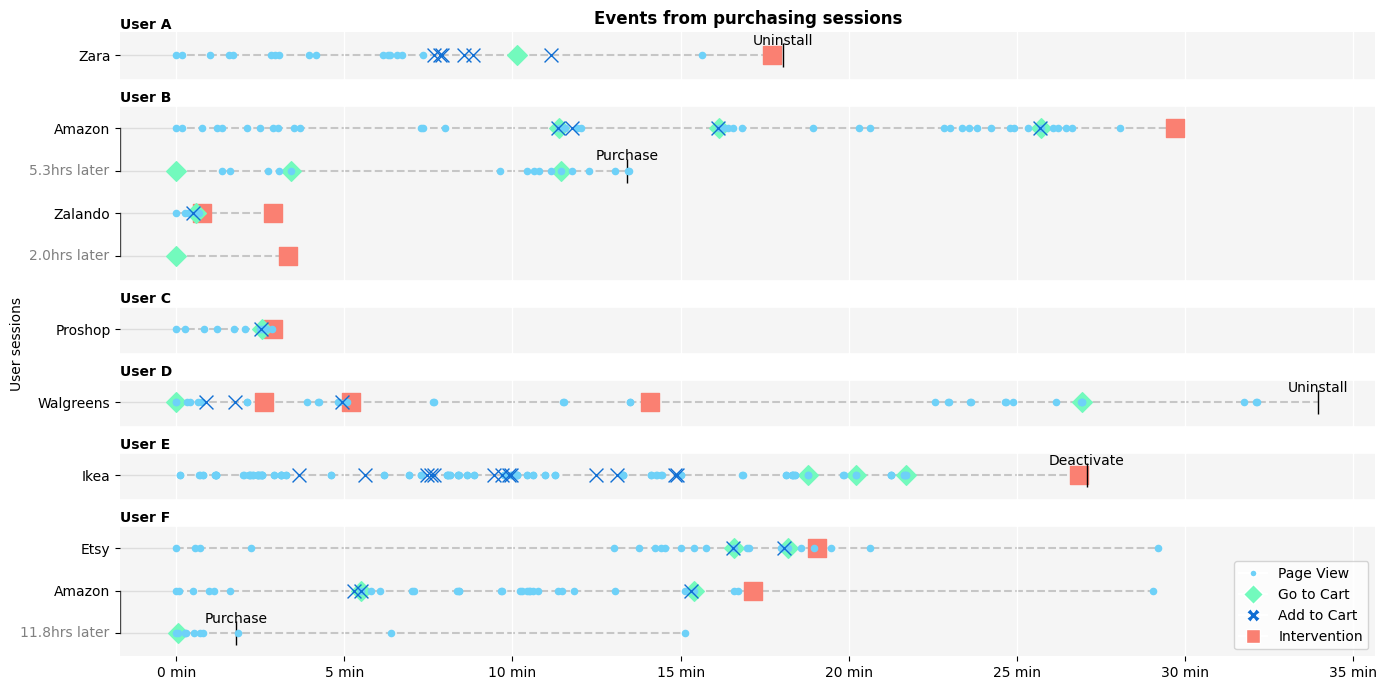

In [44]:
num_sessions = len(session_timelines)

vertical_spacing = 0.12
unique_users = len(set(event['user_id'] for timeline in session_timelines for event in timeline))
user_gap = 0.08
height = num_sessions * vertical_spacing + (unique_users - 1) * user_gap

# Calculate vertical spacing for each user
y_positions = np.linspace(0.2, num_sessions * vertical_spacing, num_sessions)
user_gaps_y = []

last_user_id = session_timelines[0][0]["user_id"]
accumuldated_user_gap = 0
for i in range(num_sessions):
    uid = session_timelines[i][0]["user_id"]
    if uid != last_user_id:
        accumuldated_user_gap += user_gap
        user_gaps_y.append(y_positions[i] + accumuldated_user_gap - (user_gap + vertical_spacing) / 2)
        
    last_user_id = uid
    y_positions[i] += accumuldated_user_gap

session_y_map = {session_timelines[i][0]['session_id']: y_pos for i, y_pos in enumerate(y_positions)}


plt.figure(figsize=(14, 7))

# First pass: plot the connecting lines for each user
for session_timeline in session_timelines:
    session_id = session_timeline[0]['session_id']
    max_time = session_timeline[-1]['time']
    y_pos = session_y_map[session_id]

    # Connect points with lines
    plt.plot([0, max_time], [y_pos, y_pos], '--', color="gray", alpha=0.4, zorder=0)

    for event in session_timeline:
        plt.scatter(
            event['time'], 
            y_pos,  # Fixed y-position for timeline
            color=event['color'],
            s=event['size'],
            marker=event['marker'],
            zorder=event['zorder'],
            linewidth=1
        )

        if event['workaround']:
            plt.text(
                event['time'],
                y_pos + 0.02,  # Increased vertical positionion
                event['workaround'],
                ha='center',
                va='bottom',
                fontsize=10,  # Slightly larger font
                color='black',
            )

        if event['type'] == "place-order":
            plt.text(
                event['time'],
                y_pos + 0.02,  # Increased vertical positionion
                "Purchase",
                ha='center',
                va='bottom',
                fontsize=10,  # Slightly larger font
                color='black',
            )

# Add grid lines for each user's position
y_padding = 0.06
plt.ylim(0.2 - y_padding, height + y_padding)
for y_pos in y_positions:
    plt.plot([-100, 0], [y_pos, y_pos], color='lightgray', alpha=0.7, linewidth=1, zorder=1)
    #plt.line(y=y_pos, color='lightgray', linestyle='-', alpha=0.3, zorder=2)


# Add session labels on the y-axis
start = num_sessions - 1
#session_labels = [f'User {session_timelines[i][0]["user_id"]}' for i in range(num_sessions)]  # A, B, C, etc.
session_labels = [f'{domainToName(session_timelines[i][-2]["domain"])}' for i in range(num_sessions)]  # A, B, C, etc.
plt.yticks(y_positions, session_labels)
plt.ylabel("User sessions", labelpad=10)


x_lim_min = -100

# Add domain labels underneath the session labels
"""for i, session_timeline in enumerate(session_timelines):
    domain = domainToName(session_timeline[0]['domain'])
    plt.text(
        x_lim_min-20,  # Place text to the left of the y-axis
        y_positions[i] - .05,
        domain,
        ha='right',
        va='center',
        color='gray',
        fontsize=10,
    )"""

seen_uids = set()

for i, session_timeline in enumerate(reversed(session_timelines)):
    uid = session_timeline[0]['user_id']
    reversed_i = num_sessions - 1 - i
    
    # Only display domain for first time we see this user
    if uid not in seen_uids:
        """ plt.text(
            x_lim_min-20,  # Place text to the left of the y-axis
            y_positions[reversed_i] + .05,
            f"User {uid}",
            ha='right',
            va='center',
            fontweight="bold",
            fontsize=10,
        ) """
        plt.text(
            x_lim_min,  # Place text to the left of the y-axis
            y_positions[reversed_i] + .08,
            f"User {uid}",
            ha='left',
            va='center',
            fontweight="bold",
            fontsize=10,
        )
        seen_uids.add(uid)

# Add time between
for i in range(len(session_timelines)-1):
    if session_timelines[i][0]['domain'] != session_timelines[i+1][0]['domain']:
        continue
    first_event = session_timelines[i+1][0]["timestamp"]
    last_event = session_timelines[i][-1]["timestamp"]
    time_from_first = (first_event - last_event).total_seconds() / 3600
    
    plt.text(
        x_lim_min - 20,  # Place text in a fixed position
        y_positions[i],
        f"{abs(time_from_first):.1f}hrs later",
        bbox=dict(boxstyle="square", facecolor="white", edgecolor="none", alpha=1),
        ha='right',
        va='center',
        color='gray',
        fontsize=10,
    )

    plt.plot([x_lim_min, x_lim_min], [y_positions[i], y_positions[i+1]], color='black', alpha=0.7, linewidth=1, zorder=1)

# Add some white inbetween users to make them stand out
for y in user_gaps_y:
    plt.plot([x_lim_min, 2300], [y, y], color='white', linestyle='-', linewidth=20, zorder=2)

for i in range(num_sessions):
    print(f"Session {session_labels[i]}: {session_timelines[i][0]['session_id']} {session_timelines[i][0]['user_id']}")


x_positions = np.linspace(0, 2100, 8)

# Convert seconds to minutes and format as integer values
minute_labels = [f'{int(x/60)} min' for x in x_positions]
plt.xticks(x_positions, minute_labels)
plt.xlim(x_lim_min, 2140)


# Set up the plot with improved aesthetics
plt.title(f'Events from purchasing sessions', fontweight='bold')

# Create legend elements based on event_styles
legend_elements = [
    plt.Line2D([0], [0], marker=event_styles['page-view']['marker'], color='w', 
               markerfacecolor=event_styles['page-view']['color'], 
               markersize=10, label='Page View'),
    plt.Line2D([0], [0], marker=event_styles['checkout']['marker'], color='w', 
               markerfacecolor=event_styles['checkout']['color'], 
               markersize=10, label='Go to Cart'),
    plt.Line2D([0], [0], marker='X', color='w', 
               markerfacecolor=event_styles['add-to-cart']['color'], 
               markersize=10, label='Add to Cart'),
    plt.Line2D([0], [0], marker=event_styles['enforce_wait_modal_shown']['marker'], color='w', 
               markerfacecolor=event_styles['enforce_wait_modal_shown']['color'], 
               markersize=10, label='Intervention'),
]
plt.legend(handles=legend_elements, loc='lower right')





ax = plt.gca()
#ax.grid(color='white', linewidth=1, axis='y', alpha=0, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=2)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig('plots/purchasing_session_events.png', dpi=300, bbox_inches='tight')

plt.show()